# Creating surface forcing

In [1]:
import os
from roms_tools import Grid, SurfaceForcing           

As always, the first step is to create our grid. Let's start with a coarse-resolution grid with a horizontal resolution of 2000km/100 = 20km.

In [2]:
grid = Grid(
    nx=520,  # number of grid points in x-direction
    ny=450,  # number of grid points in y-direction
    size_x=1560,  # domain size in x-direction (in km)
    size_y=1350,  # domain size in y-direction (in km)
    center_lon=-17.75,  # longitude of the center of the domain
    center_lat=30,  # latitude of the center of the domain
    rot=-15,  # rotation of the grid (in degrees)
    N=40,  # number of vertical layers
    verbose=True,
)

2025-12-22 13:01:24 - INFO - === Creating the horizontal grid ===
2025-12-22 13:01:25 - INFO - Total time: 0.169 seconds
2025-12-22 13:01:25 - INFO - ================================================================================================
2025-12-22 13:01:25 - INFO - === Deriving the mask from coastlines ===
2025-12-22 13:01:25 - INFO - Total time: 0.425 seconds
2025-12-22 13:01:25 - INFO - ================================================================================================
2025-12-22 13:01:25 - INFO - === Generating the topography using ETOPO5 data and hmin = 5.0 meters ===
2025-12-22 13:01:25 - INFO - Reading the topography data: 0.031 seconds
2025-12-22 13:01:25 - INFO - Regridding the topography: 0.015 seconds
2025-12-22 13:01:25 - INFO - Domain-wide topography smoothing: 0.047 seconds
2025-12-22 13:01:31 - INFO - Local topography smoothing: 5.895 seconds
2025-12-22 13:01:31 - INFO - Total time: 5.997 seconds
2025-12-22 13:01:31 - INFO - ========================

Next, we specify the temporal range that we want to make the surface forcing for.

In [3]:
from datetime import datetime

In [4]:
start_time = datetime(2013, 1, 1)
end_time = datetime(2013, 3, 31)

`ROMS-Tools` can create two types of surface forcing:

* physical surface forcing like 10m wind, shortwave radiation, and air temperature at 2m
* biogeochemical (BGC) surface forcing like atmospheric pCO2

Unlike initial conditions data, ROMS can read multiple surface forcing files, so we create these two types separately in the following sections.

## Physical surface forcing

In this section, we use ERA5 data to construct the physical surface forcing. There are two ways to access the data:

- **Stream directly from the cloud** (no download required)
- **Use locally pre-downloaded files** by specifying the path

**Streaming** is convenient: there's no need to download data in advance.  
**Local files**, on the other hand, can reduce initialization time if you already have the data available.

Let's explore both options with these keyword arguments:

In [5]:
surface_forcing_kwargs = {
    "grid": grid,
    "start_time": start_time,
    "end_time": end_time,
    "type": "physics",
    "model_reference_date": datetime(2000, 1, 1), # this is the default
    "wind_dropoff": True,
    "correct_radiation": False,
    "use_dask": True
}

### Streaming Cloud-based ERA5 Data

Let's begin by exploring the streaming approach. This method uses [ARCO (Analysis-Ready, Cloud Optimized) ERA5 data](https://github.com/google-research/arco-era5/?tab=readme-ov-file#025-pressure-and-surface-level-data) from the public Google Cloud Storage bucket:
```bash
gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3
```
To activate the streaming approach in ROMS-Tools, simply omit the path in the `source` or explicitly provide the cloud storage URL:

* `source = {"name": "ERA5"}`
* `source = {"name": "ERA5", "path": "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"}`

<div class="alert alert-info">

Note

Streaming **requires** `use_dask = True` since the underlying data format is Zarr, which supports lazy loading and chunked access via Dask. [Here](https://roms-tools.readthedocs.io/en/latest/using_dask.html) you can learn more about using `Dask` with `ROMS-Tools`.

</div>

In [6]:
surface_forcing = SurfaceForcing(
    **surface_forcing_kwargs,
    source={"name": "ERA5"},
)

2025-12-22 13:01:31 - INFO - No path specified for ERA5 source; defaulting to ARCO ERA5 dataset on Google Cloud.
2025-12-22 13:03:22 - INFO - Data will be interpolated onto the grid coarsened by factor 2. Remember to set `interp_frc = 1` in your `bulk_frc.opt` ROMS option file.


Instantiating the surface forcing took over 1.5 minutes, even though no computations have been performed yet due to Dask’s lazy evaluation. **This delay results from streaming data from the cloud.** 

The surface forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property. Indeed, all variables are Dask arrays representing lazy-loaded data.

In [7]:
surface_forcing.ds

<xarray.Dataset> Size: 4GB
Dimensions:   (time: 2137, eta_rho: 227, xi_rho: 262)
Coordinates:
    abs_time  (time) datetime64[ns] 17kB 2013-01-01 ... 2013-03-31
  * time      (time) float64 17kB 4.749e+03 4.749e+03 ... 4.838e+03 4.838e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 508MB dask.array<chunksize=(1, 227, 262), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 508MB dask.array<chunksize=(1, 227, 262), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 508MB dask.array<chunksize=(1, 227, 262), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 508MB dask.array<chunksize=(1, 227, 262), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 508MB dask.array<chunksize=(1, 227, 262), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 508MB dask.array<chunksize=(1, 227, 262), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 508MB dask.array<chunksize=(1, 227, 262), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    3.3.0
    start_time:            2013-01-01 00:00:00
    end_time:              2013-03-31 00:00:00
    source:                ERA5
    correct_radiation:     False
    wind_dropoff:          True
    use_coarse_grid:       True
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

`ROMS-Tools` has found 505 time stamps within our specified time range. Let's double-check that `ROMS-Tools` has selected the correct times.

In [8]:
surface_forcing.ds.time

<xarray.DataArray 'time' (time: 2137)> Size: 17kB
array([4749.      , 4749.041667, 4749.083333, ..., 4837.916667, 4837.958333,
       4838.      ], shape=(2137,))
Coordinates:
    abs_time  (time) datetime64[ns] 17kB 2013-01-01 ... 2013-03-31
  * time      (time) float64 17kB 4.749e+03 4.749e+03 ... 4.838e+03 4.838e+03
Attributes:
    long_name:  relative time: days since 2000-01-01 00:00:00
    units:      days

<div class="alert alert-info">

Note

The `time` variable shows relative time, i.e., days since the model reference date (here set to January 1, 2000 by default). The `abs_time` coordinate shows the absolute time. The ERA5 data provided to `ROMS-Tools` has hourly frequency; this temporal frequency is inherited by `surface_forcing`.
    
</div>

To visualize any of the surface forcing fields, we can use the `.plot` method.

[########################################] | 100% Completed | 2.02 sms


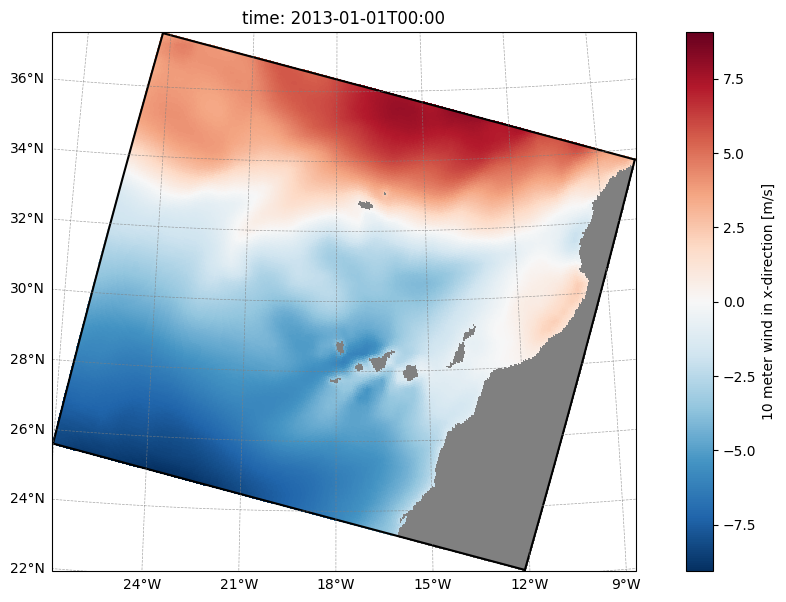

In [9]:
surface_forcing.plot("uwnd", time=0)

[########################################] | 100% Completed | 1.11 sms


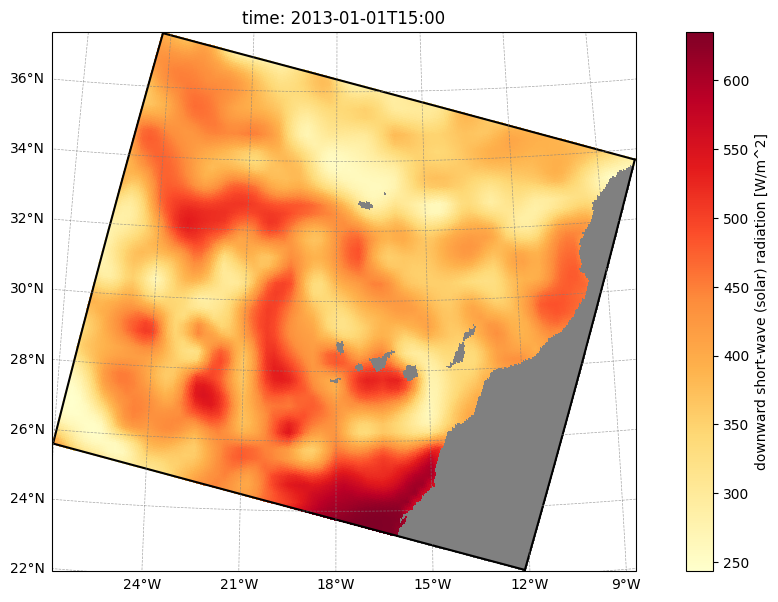

In [10]:
surface_forcing.plot("swrad", time=15)

The spatial dimensions `eta_rho` and `xi_rho` in the surface forcing dataset remain 202, matching their original lengths in the `grid_10km`.

## Saving as NetCDF or YAML file
Once we have decided which of the surface forcing versions we actually want to use, we can save the dataset as a NetCDF file.

The spatial dimensions `eta_rho` and `xi_rho` in the surface forcing dataset remain 202, matching their original lengths in the `grid_10km`.

We need to specify the desired target path.

In [ ]:
datadir = "../data/"
surface_forcing.save(os.path.join(datadir, "roms_frc.nc"), group=True)

2025-12-22 15:49:17 - INFO - Writing the following NetCDF files:
../data/roms_frc_201301.nc
../data/roms_frc_201302.nc
../data/roms_frc_201303.nc


[##########                              ] | 26% Completed | 27m 20ss

We can also export the parameters of our `SurfaceForcing` object to a YAML file.

In [ ]:
yaml_filepath = os.path.join(datadir, "surface_forcing.yaml")

In [ ]:
surface_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [ ]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)